In [123]:
import pandas
import numpy as np
from glob import glob
import os
from datetime import datetime,timedelta
import pickle
import logging
import logging.handlers
import numpy as np
pandas.set_option('display.max_columns', None)
from functools import reduce  # For Python 3.x
from itertools import chain
import matplotlib.pyplot as plt
import math
from calendar import monthrange
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.ticker import NullFormatter
import math
import matplotlib.pyplot as plt
import random
from datetime import datetime,timedelta
import warnings
import numpy
import bisect
from bisect import bisect_right 
import operator
from collections import Counter
from joblib import Parallel, delayed
from sklearn import metrics
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
print("warings")
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.ticker as mtick
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = None

warings


In [0]:
###############################################################################
# READING CASES REPORTING FOR VARIOUS COUNTRIES
###############################################################################

start = datetime(2020,1,21).date()
number_of_days_ahead_max = 120
baseline_ = pandas.DataFrame()

for i in range(0,number_of_days_ahead_max):
  day = start + timedelta(days=i)
  
  if (day<datetime.now().date())&(day>=datetime(2020,1,22).date()):
    try:
      temp = pandas.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"+day.strftime("%m-%d-%Y")+".csv")
      
    except:
      d = d + timedelta(days=-1)
      temp = pandas.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"+d.strftime("%m-%d-%Y")+".csv")

    if(day>=datetime(2020,3,22).date()):
      temp.rename(columns={"Province_State": "Province/State"},inplace=True)
      temp.rename(columns={"Country_Region": "Country/Region"},inplace=True)
      temp.rename(columns={"Last_Update": "Last Update"},inplace=True)

    temp["Active"] = temp["Confirmed"]-temp["Recovered"]-temp["Deaths"]
    baseline_ = baseline_.append(temp)

baseline_["Last Update_"] = pd.to_datetime(baseline_["Last Update"])
baseline_["Last Update_"] = baseline_["Last Update_"]
baseline_["Day"] = baseline_["Last Update_"].dt.date
baseline_ = baseline_.sort_values(["Day","Last Update_"],ascending=[True,True])
baseline_["Country/Region"].replace("United States","US",inplace=True)
baseline_["Country/Region"].replace("Russian Federation","Russia",inplace=True)
baseline_["Country/Region"].replace("China","Mainland China",inplace=True)
baseline_["Country/Region"].replace("UK","United Kingdom",inplace=True)
baseline_["Province/State"].fillna(0,inplace=True)

In [0]:
baseline_bis = baseline_.groupby(["Day","Country/Region","Province/State"],as_index=False).agg({"Confirmed":"last","Deaths":"last","Recovered":"last","Active":"last"})

In [0]:
###############################################################################
# READING POPULATION FOR VARIOUS COUNTRIES
###############################################################################

population = pandas.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")
population = population.sort_values("Year",ascending=False)
population = population.groupby("Country Name",as_index=False).agg({"Year":"first","Value":"first"})
population.replace("Iran, Islamic Rep.","Iran",inplace=True)
population.replace("Korea, Rep.","Korea, South",inplace=True)
population.replace("United States","US",inplace=True)
population.replace("Czech Republic","Czechia",inplace=True)
population.replace("Egypt, Arab Rep.","Egypt",inplace=True)
population.replace("Russian Federation","Russia",inplace=True)
population.replace("China","Mainland China",inplace=True)

In [0]:
###############################################################################
# READING GOVERNEMENT MEASURES FOR VARIOUS COUNTRIES
###############################################################################
governement = pandas.read_csv("https://raw.githubusercontent.com/jriflying12/COVID-19/master/Governement_bis.csv",delimiter=",")
governement["Date"] = pd.to_datetime(governement["Date"])
#https://auravision.ai/covid19-lockdown-tracker/

In [0]:
###############################################################################
# READING TESTING FOR VARIOUS COUNTRIES
###############################################################################

In [0]:
testing = pandas.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/testing/covid-testing-all-observations.csv")
testing["country"] = testing["Entity"].str.split('-').str[0]
testing["country"] = testing["country"].str[:-1]
testing["testing_type"] = testing["Entity"].str.split('-').str[1]
testing["testing_type"] = testing["testing_type"].str[1:]
testing.rename(columns={"Date": "Day"},inplace=True)
testing["Day"] = pd.to_datetime(testing["Day"])
testing = testing.sort_values(by="Day",ascending=True)

In [0]:
###############################################################################
# READING EXPECTED DEATH FOR VARIOUS COUNTRIES
###############################################################################

In [0]:
expected_deaths = pandas.read_csv("https://raw.githubusercontent.com/jriflying12/COVID-19/master/Expected_Fatality.csv", encoding = 'utf8',sep=";")
expected_deaths = expected_deaths.applymap(lambda x: str(x.replace(',','.')))
expected_deaths["Expected fatality"] = expected_deaths["Expected fatality"].astype(float)
expected_deaths.replace("China","Mainland China",inplace=True)
expected_deaths.replace("United States of America","US",inplace=True)
expected_deaths.replace("Russian Federation","Russia",inplace=True)

In [0]:
###############################################################################
# DEFINING PROBABILITY FUNCTIONS USED FOR SEIR MODEL
###############################################################################

def weib(x,n,a):
  return [(a / n) * (x_ / n)**(a - 1) * np.exp(-(x_ / n)**a) for x_ in x], n*np.log(2)**(1/a)

def revamp_prob(prob):
  prob_ = [0]*len(prob)
  prob_[0] = prob[0]
  
  for i in range(1,len(prob_)):
    factor = 1
    for j in range(0,i):
      factor = factor*(1-prob_[j]) 
    
    prob_[i] = prob[i]/factor

  for i in range(0,len(prob_)):
    prob_[i] = 1-prob_[i]

  return prob_

###############################################################################
# DEFINING PROPAGATION FUNCTION USED FOR SEIR MODEL
###############################################################################

def split(pop,prob,gauss_m=None,gauss_s=None,stoch=0):

  pop_stay = [0]*len(pop)
  pop_leave = [0]*len(pop)
  
  if gauss_m==None:
    gauss_m = 1
    gauss_s = 0

  for i in range(0,len(pop)):

    if stoch==0:

      if ((pop[i]*gauss_m)<=50)&(pop[i]*gauss_m>0):

        if gauss_s==0:
          aa = numpy.random.uniform(0, 1,int(pop[i]))
          bb = [prob[i]]*int(pop[i])
          cc =  sum(aa<=bb)
          pop_stay[i] = int(1*cc)
          pop_leave[i] = pop[i]-cc

        else:

          for j in range(0,pop[i]):
            people_meet = int(abs(numpy.random.normal(gauss_m,gauss_s,1)))
            aa = numpy.random.uniform(0, 1,people_meet)
            bb = [prob[i]]*int(people_meet)
            cc =  sum(aa<=bb)
            pop_stay[i] = pop_stay[i]+int(1*cc)
            pop_leave[i] = pop_leave[i]+people_meet-cc

      else:

        pop_stay[i] = int(gauss_m*prob[i]*pop[i])
        pop_leave[i] = int(gauss_m*(pop[i]-pop_stay[i]))

    else:

      pop_stay[i] = gauss_m*prob[i]*pop[i]
      pop_leave[i] = pop[i]- gauss_m*prob[i]*pop[i]

  return pop_stay, pop_leave

In [0]:
###############################################################################
# SEIR MODEL
###############################################################################

def run_montecarlo(m,
                    exposed_to_infectious_time_param,
                    infectious_to_recovery_time_param,
                    infectious_to_recovery_severe_param,
                    infectious_to_die_severe_param,
                    people_meet_m_param,
                    people_meet_s_param,
                    day_modification_param,
                    r_beta_param,
                    asymptomatic_param,
                    mild_param,
                    fatality_param,
                    days_param,
                    measures1_param,
                    measures2_param,
                    beta_param,N,stoch):
  
  #############################################################################
  # Execution parameters
  #############################################################################

  print_ = False
  exposed_to_infectious_time_ = exposed_to_infectious_time_param
  infectious_to_recovery_time_ = infectious_to_recovery_time_param
  infectious_to_recovery_severe_ = infectious_to_recovery_severe_param
  infectious_to_die_severe_ = infectious_to_die_severe_param
  beta = beta_param
  people_meet_m = people_meet_m_param
  people_meet_s = people_meet_s_param
  day_modification = day_modification_param
  r_beta = r_beta_param
  asymptomatic = asymptomatic_param
  mild = mild_param
  fatality = fatality_param
  N = N
  measures = [measures1_param,measures2_param]
  days= 120 #measures[0][len(measures1_param)-1]+20
  #days = days_param
  #days=measures1_param+(datetime.now()-lockdown_start).days
  init_cases = 3

  #############################################################################
  # Results table initialization
  #############################################################################
   
  S_ = []
  S_.append(N-init_cases)

  E = [0]*len(exposed_to_infectious_time_)
  E[0] = init_cases
  E_ = []
  E_.append(sum(E))

  IA = [0]*len(infectious_to_recovery_time_)
  IA_ = []
  IA_.append(sum(IA))
  IA_cum = []
  IA_cum.append(sum(IA))

  IM = [0]*len(infectious_to_recovery_time_)
  
  IM_ = []  
  IM_.append(sum(IM))
  IM_cum = []
  IM_cum.append(sum(IM))

  ISD = [0]*len(infectious_to_die_severe_)
  ISD_ = []
  ISD_.append(sum(ISD))
  ISD_cum = []
  ISD_cum.append(sum(ISD))

  ISR = [0]*len(infectious_to_recovery_severe_)
  ISR_ = []
  ISR_.append(sum(ISR))
  ISR_cum = []
  ISR_cum.append(sum(ISR))

  R = [0]
  R_ = []
  R_.append(sum(R))

  D = [0]
  D_ = []
  D_.append(sum(D))

  beta0 = beta
  factor = 1#(1+random.uniform(-0.3,0.3))
  day_lockdown = days

  #############################################################################
  # 1 monte carlo run
  #############################################################################

  for i in range(1,days):
    
    #print("#############")

    alpha = 1
    
    #1) Change of status compared to previous status
    #print(datetime.now())
    
    remainE, leaveE = split(E,exposed_to_infectious_time_,stoch=stoch)
    remainIA, leaveIA = split(IA,infectious_to_recovery_time_,stoch=stoch)  
    remainIM, leaveIM = split(IM,infectious_to_recovery_time_,stoch=stoch)
    remainISR, leaveISR = split(ISR,infectious_to_recovery_severe_,stoch=stoch)
    remainISD, leaveISD = split(ISD,infectious_to_die_severe_,stoch=stoch)

    #2) Computation of newly exposed
    #print(datetime.now())

        #a) time adjustment of beta depending on governement measures
    
    if measures!=None:
        #ind = bisect_right(measures[0], i)-1
        #print(D_[i-1])
        #print(measures[0][0])
        #print(measures[1][0])
        if D_[i-1]>=measures[0][0]:
          alpha = factor*measures[1][0]
          if(day_lockdown==days):
            day_lockdown = i
          if alpha>1:
            alpha = 1
    
        #b) newly exposed from asymptomatic, mild and severe. We assume the likelihood to infect people is constant over time
    
    new_E_IA,n = split([sum(IA)],[alpha*(r_beta*beta0*S_[i-1]/N)],people_meet_m,people_meet_s,stoch=stoch)
    new_E_IO,n = split([sum(IM[:day_modification]+ISR[:day_modification]+ISD[:day_modification])],[alpha*(beta0*S_[i-1]/N)],people_meet_m,people_meet_s,stoch=stoch)

        #c) update of the current exposed
    
    E = [sum(new_E_IA) + sum(new_E_IO)] + remainE[:-1] 
    E_.append(sum(E))

    #3) Computation of the newly infectious
    #print(datetime.now())
    
        #a) Split asymptomatic / symptomatic
    
    new_IA, new_I = split([sum(leaveE)],[asymptomatic],stoch=stoch)

        #b) Split mild and sever for symptomatic
    
    new_IM, new_IS = split([sum(new_I)],[mild],stoch=stoch)
    new_ISR, new_ISD = split([sum(new_IS)],[1-fatality],stoch=stoch)

        #c) Update infectious population
    
    IA = [sum(new_IA)]+remainIA[:-1] 
    IA_.append(sum(IA))
    IA_cum.append(IA_cum[i-1]+sum(new_IA))

    IM = [sum(new_IM)]+ remainIM[:-1] 
    IM_.append(sum(IM))
    IM_cum.append(IM_cum[i-1]+sum(new_IM))

    ISR = [sum(new_ISR)]+ remainISR[:-1] 
    ISR_.append(sum(ISR))
    ISR_cum.append(ISR_cum[i-1]+sum(new_ISR))

    ISD = [sum(new_ISD)] + remainISD[:-1] 
    ISD_.append(sum(ISD))
    ISD_cum.append(ISD_cum[i-1]+sum(new_ISD))
    
    #4) Computation of newly recovered / dead
    #print(datetime.now())
    
    R[0] = sum(leaveIA) + sum(leaveIM) + sum(leaveISR) 
    R_.append(R_[i-1]+sum(R))
    
    D[0] =  sum(leaveISD)
    D_.append(D_[i-1]+sum(D))

    #5) Reduce the susceptible population
    #print(datetime.now())

    S_.append(S_[0]-E_[i]-IA_[i]-IM_[i]-ISR_[i]-ISD_[i]-R_[i]-D_[i])
    if S_[i]<0:
      S_[i] = 0

    if (print_):
      print("#############")
      print(i)
      print("E")
      print(E)
      print("remainE")
      print(remainE)
      print("leaveE")
      print(leaveE)
      print("IA")
      print(IA)
      print("remainIA")
      print(remainIA)
      print("leaveIA")
      print(leaveIA)
      print("ISM")
      print(IM)
      print("remainISM")
      print(remainIM)
      print("leaveISM")
      print(leaveIM)
      print("ISSR")
      print(ISR)
      print("remainISSR")
      print(remainISR)
      print("leaveISSR")
      print(leaveISR)
      print("ISSD")
      print(ISD)
      print("remainISD")
      print(remainISD)
      print("leaveISD")
      print(leaveISD)
      print("new_E_IA")
      print(sum(new_E_IA))
      print("new_E_IM")
      print(sum(new_E_IM))
      print("new_E_ISR")
      print(sum(new_E_ISR))
      print("new_E_ISD")
      print(sum(new_E_ISD))
      print("new_IA")
      print(new_IA)
      print("new_IM")
      print(new_IM)
      print("new_IR")
      print(new_ISR)
      print("new_ISD")
      print(new_ISD)
  
  return S_,E_,IA_,IM_,ISR_,ISD_,IA_cum,IM_cum,ISR_cum,ISD_cum,R_,D_,m,day_lockdown

#############################################################################
# monte carlo run function
#############################################################################

def run_scenario(i2R_weib=14,
                i2Rs_weib=24,
                i2Ds_weib=7,
                people_meet_m_param=40,
                people_meet_s_param=20,
                day_modification_param=5,
                r_beta_param=0.2,
                asymptomatic_param=0.4,
                mild_param=0.8,
                fatality_param=0.1,
                days_param=180,
                measures1_param=80,
                measures2_param=0.3,
                beta_param=0.022,
                N=30000000,
                stoch=0,
                mc = 25
                ):
    
    monte_carlo = mc

    susceptible_ = pandas.DataFrame()
    exposed_ = pandas.DataFrame()
    infectiousA_ = pandas.DataFrame()
    infectiousA_cum = pandas.DataFrame()
    infectiousM_ = pandas.DataFrame()
    infectiousM_cum = pandas.DataFrame()
    infectiousSR_ = pandas.DataFrame()
    infectiousSR_cum = pandas.DataFrame()
    infectiousSD_ = pandas.DataFrame()
    infectiousSD_cum = pandas.DataFrame()
    recovered_ = pandas.DataFrame()
    dead_ = pandas.DataFrame()
    lock_ = pandas.DataFrame()

    #https://github.com/HopkinsIDD/ncov_incubation
    exposed_to_infectious_time,median_exposed_to_infectious_time = weib(range(0,13),  6.26, 2.45)
    exposed_to_infectious_time[0] = exposed_to_infectious_time[0]+ exposed_to_infectious_time[1]+ exposed_to_infectious_time[2]
    for i in range(1,len(exposed_to_infectious_time)-2):
      exposed_to_infectious_time[i] = exposed_to_infectious_time[i+2]
    
    exposed_to_infectious_time = [float(i)/sum(exposed_to_infectious_time) for i in exposed_to_infectious_time]
    exposed_to_infectious_time_ = revamp_prob(exposed_to_infectious_time)
    exposed_to_infectious_time_cum = np.cumsum(exposed_to_infectious_time)

    #https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf
    infectious_to_recovery_time,median_infectious_to_recovery_time = weib(range(0,30), i2R_weib, 4)
    infectious_to_recovery_time = [float(i)/sum(infectious_to_recovery_time) for i in infectious_to_recovery_time]
    infectious_to_recovery_time_ = revamp_prob(infectious_to_recovery_time)
    infectious_to_recovery_time_cum = np.cumsum(infectious_to_recovery_time)
    
    infectious_to_recovery_severe,mean_infectious_to_recovery_severe = weib(range(0,30), i2Rs_weib, 6)
    infectious_to_recovery_severe = [float(i)/sum(infectious_to_recovery_severe) for i in infectious_to_recovery_severe]
    infectious_to_recovery_severe_ = revamp_prob(infectious_to_recovery_severe)
    infectious_to_recovery_severe_cum = np.cumsum(infectious_to_recovery_severe)
    
    infectious_to_die_severe,mean_infectious_to_die_severe = weib(range(0,16), i2Ds_weib, 4)
    infectious_to_die_severe = [float(i)/sum(infectious_to_die_severe) for i in infectious_to_die_severe]
    infectious_to_die_severe_ = revamp_prob(infectious_to_die_severe)
    infectious_to_die_severe_cum = np.cumsum(infectious_to_die_severe)
    
    beta = beta_param
    people_meet_m = people_meet_m_param
    day_modification = day_modification_param
    r_beta = r_beta_param
    asymptomatic = asymptomatic_param
    mild = mild_param

    R0_a = 0
    R0_sm = 0
    R0_ssr = 0
    R0_ssd = 0

    for i in range(0,len(infectious_to_recovery_time_cum)): 
      R0_a = R0_a + (1-infectious_to_recovery_time_cum[i])*beta*people_meet_m*asymptomatic*r_beta
    for i in range(0,min(len(infectious_to_recovery_time_cum),day_modification)): 
      R0_sm = R0_sm + (1-infectious_to_recovery_time_cum[i])*beta*people_meet_m*(1-asymptomatic)*mild
    for i in range(0,min(len(infectious_to_recovery_severe_cum),day_modification)): 
      R0_ssr = R0_ssr + (1-infectious_to_recovery_severe_cum[i])*beta*people_meet_m*(1-asymptomatic)*(1-mild)
    for i in range(0,min(len(infectious_to_die_severe_cum),day_modification)): 
      R0_ssd = R0_ssd + (1-infectious_to_die_severe_cum[i])*beta*people_meet_m*(1-asymptomatic)*(1-mild)
    
    #print(median_exposed_to_infectious_time)
    #print("median infectious time: " + str(median_exposed_to_infectious_time))
    #print("median recovery time mild/asymptomatic: " + str(median_infectious_to_recovery_time))
    #print(median_infectious_to_recovery_time)
    #print("median recovery time severe: " + str(mean_infectious_to_recovery_severe))
    #print(mean_infectious_to_recovery_severe)
    #print("median die time severe: " + str(mean_infectious_to_die_severe))
    #print(mean_infectious_to_die_severe)
    #print("estimated R0 asymptomatic: "+ str(R0_a))
    #print("estimated R0 symptomatic mild: "+ str(R0_sm))
    #print("estimated R0 symptomatic severe recovery: "+ str(R0_ssr))
    #print("estimated R0 symptomatic severe die: "+ str(R0_ssd))
    #print("TOTAL R0: "+ str(R0_a+R0_sm+R0_ssr+R0_ssd))

    #############################################################################
    # Launch all monte carlo in parralel
    #############################################################################

    results=Parallel(n_jobs=1)(delayed(run_montecarlo)(m,
                                        exposed_to_infectious_time_,
                                        infectious_to_recovery_time_,
                                        infectious_to_recovery_severe_,
                                        infectious_to_die_severe_,
                                        people_meet_m_param,
                                        people_meet_s_param,
                                        day_modification_param,
                                        r_beta_param,
                                        asymptomatic_param,
                                        mild_param,
                                        fatality_param,
                                        days_param,
                                        measures1_param,
                                        measures2_param,
                                        beta_param,N,stoch) for m in range(monte_carlo))
    S_,E_,IA_,IM_,ISR_,ISD_,IA_cum,IM_cum,ISR_cum,ISD_cum,R_,D_,ms,day_lockdown = zip(*results)

    #############################################################################
    # Structure all the results
    #############################################################################

    for m in ms:
          susceptible_["run_"+str(m)] = S_[m]
          exposed_["run_"+str(m)] = E_[m]
          infectiousA_["run_"+str(m)] = IA_[m]
          infectiousM_["run_"+str(m)] = IM_[m]
          infectiousSR_["run_"+str(m)] = ISR_[m]
          infectiousSD_["run_"+str(m)] = ISD_[m]
          infectiousA_cum["run_"+str(m)] = IA_cum[m]
          infectiousM_cum["run_"+str(m)] = IM_cum[m]
          infectiousSR_cum["run_"+str(m)] = ISR_cum[m]
          infectiousSD_cum["run_"+str(m)] = ISD_cum[m]
          recovered_["run_"+str(m)] = R_[m]
          dead_["run_"+str(m)] = D_[m]
          lock_["run_"+str(m)] = day_lockdown[m]
          #print(day_lockdown[m])
    
    #print(dead_)
    #print("##############")
    #init_delta=(min(lockdown["Date"].dt.date)-min(baseline_["Day"])).days
    #print(init_delta)
    #shift = day_lockdown[0]-init_delta
    #print(shift)
    #values = dead_["run_0"][shift:shift+len(baseline_)].reset_index()
    #print(values)
    #maeDead=math.sqrt(sum(values["run_0"]-baseline_["Dead"])**2)

    #print(maeDead)
    #maeActive=1
    return susceptible_,\
            exposed_,\
            infectiousA_,\
            infectiousM_,\
            infectiousSR_,\
            infectiousSD_,\
            infectiousA_cum,\
            infectiousM_cum,\
            infectiousSR_cum,\
            infectiousSD_cum,\
            recovered_,\
            dead_#,\
    #        day_lockdown[0],\
    #        maeDead,\
    #        maeActive


In [0]:
###############################################################################
# SELECT COUNTRY TO BE MODELED
###############################################################################

#Mainland China
#US
#France
#Germany
#United Arab Emirates
#India
#Italy
#United Kingdom
#Russia
#Spain
#Belgium
#Egypt
#Oman
#Bahrain
#Kuwait
#Qatar
#Saudi Arabia
#Brazil
country = "Italy"
province=0

population__ = population[population["Country Name"].str.contains(country)]["Value"].sum()
expected_fatality__ = expected_deaths[expected_deaths["Country"]==country]["Expected fatality"].sum()
governement_ = governement[governement["country"]==country]
exposed_to_death = lag = 10

if province==0:
  baseline_bis__ = baseline_bis[baseline_bis["Country/Region"]==country].groupby("Day",as_index=False).agg({"Confirmed":"sum","Deaths":"sum","Recovered":"sum","Active":"sum"})
  baseline_bis__.rename(columns={"Country/Region": "Place"},inplace=True)
  measures_ = governement[(governement["Country"]==country)]
  testing__ = testing[(testing["country"]==country)&(testing["testing_type"]=="tests performed")]
  testing__["test_per_day"] =  testing__["Cumulative total"].interpolate().diff()/testing__["Day"].diff().dt.days
  baseline_bis__["Actual"] = baseline_bis__["Deaths"].shift(-exposed_to_death)/expected_fatality__
else:
  baseline_bis__ =  baseline_bis[baseline_bis["Province/State"]==province].groupby("Day",as_index=False).agg({"Confirmed":"sum","Deaths":"sum","Recovered":"sum","Active":"sum"})
  baseline_bis__.rename(columns={"Province/State": "Place"},inplace=True)
  measures__ = governement[(governement["Country"]==country)&(governement["Province"]==province)]

Text(0, 0.5, 'Number of test conducted daily')

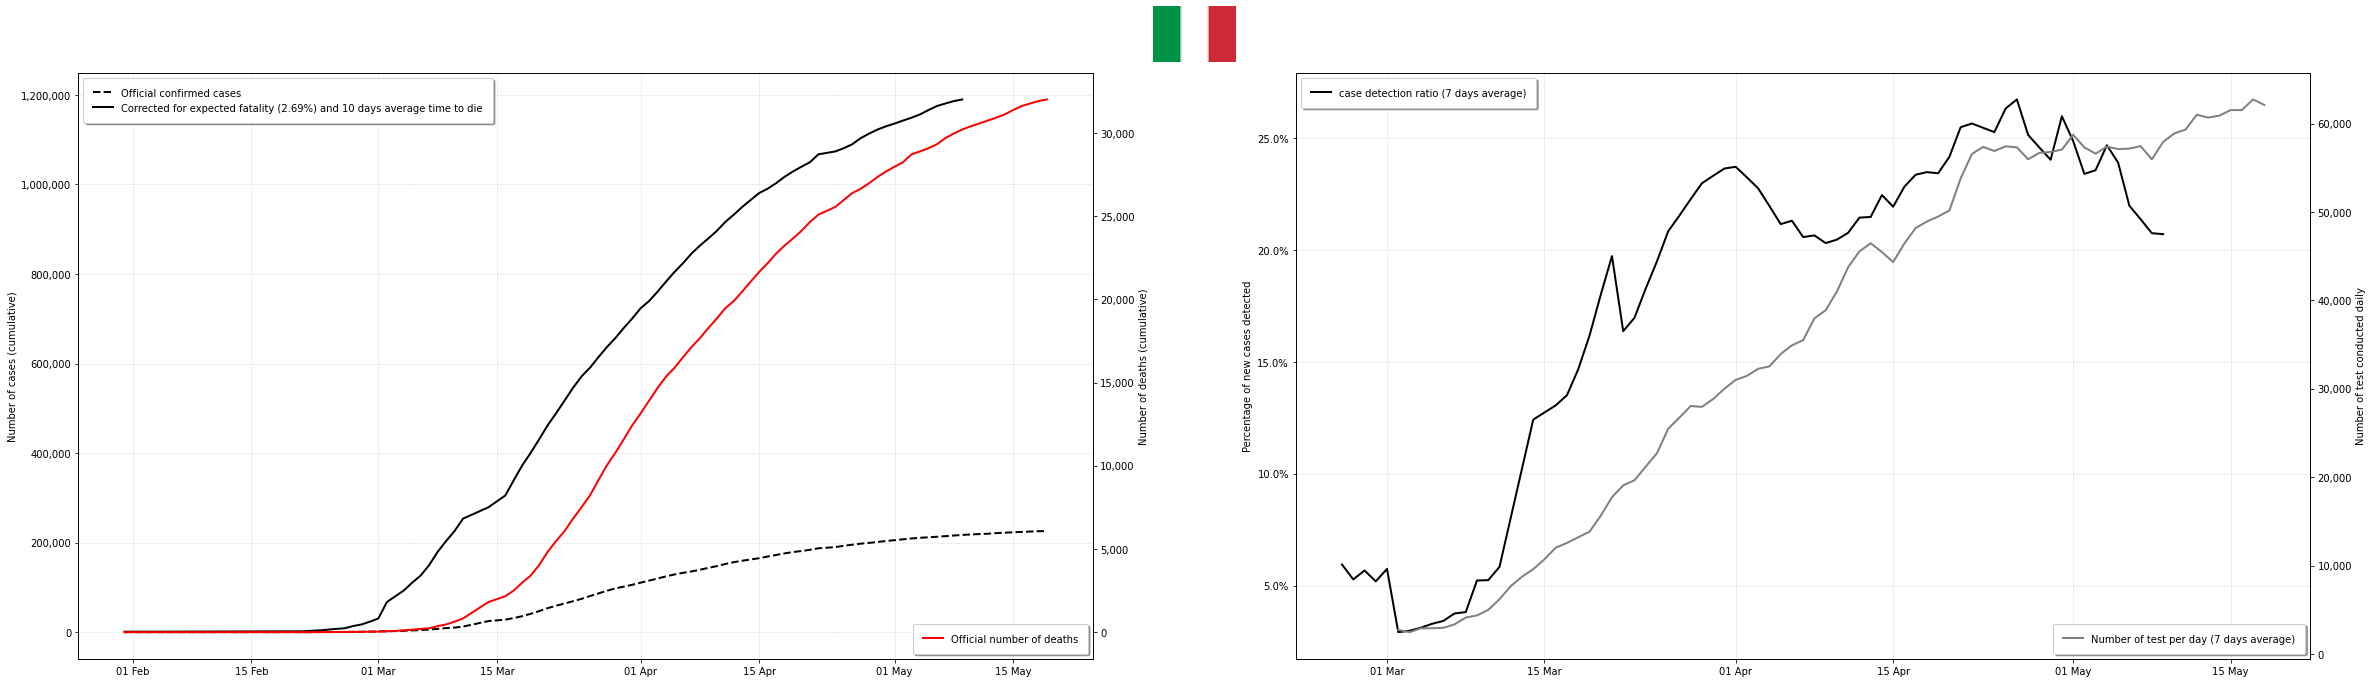

In [167]:
fig = plt.figure(constrained_layout=True, figsize=(40,12))
gs = fig.add_gridspec(10, 2)
ax_0 = fig.add_subplot(gs[0, :])
ax_1 = fig.add_subplot(gs[1:, 0])
ax_2 = fig.add_subplot(gs[1:, 1])

#top
#https://www.countryflags.com/en/india-flag-emoji.html
logo = plt.imread("https://raw.githubusercontent.com/jriflying12/COVID-19/master/"+country+".png")
img = ax_0.imshow(logo)
ax_0.axis('off')

#Left graph
ax_1.plot(baseline_bis__["Day"],baseline_bis__["Confirmed"],linestyle='--',color="k",linewidth=2,label="Official confirmed cases")
ax_1.plot(baseline_bis__["Day"],baseline_bis__["Actual"],color="k",linewidth=2,label="Corrected for expected fatality ("+str(100*expected_fatality__)+"%) and "+str(exposed_to_death)+" days average time to die")
ax_1_2=ax_1.twinx()
ax_1_2.plot(baseline_bis__["Day"],baseline_bis__["Deaths"],color="r",linewidth=2,label="Official number of deaths")
date_form = DateFormatter("%d %b")
ax_1.xaxis.set_major_formatter(date_form)
ax_1.set_ylabel('Number of cases (cumulative)')
ax_1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax_1.grid(color='lightgray', linestyle='--', linewidth=0.5)
ax_1.legend(loc='upper left',fancybox=True, framealpha=1, shadow=True, borderpad=1)
ax_1_2.legend(loc='lower right',fancybox=True, framealpha=1, shadow=True, borderpad=1)
ax_1_2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax_1_2.set_ylabel('Number of deaths (cumulative)')


#right graph
ax_2.plot(baseline_bis__["Day"],100*(baseline_bis__["Confirmed"].diff(7)/(baseline_bis__["Actual"].diff(7))),color="k",linewidth=2,label="case detection ratio (7 days average)")
ax_2_2=ax_2.twinx()
ax_2_2.plot(testing__["Day"],testing__["test_per_day"].rolling(7).mean(),color="grey",linewidth=2,label="Number of test per day (7 days average)")
date_form = DateFormatter("%d %b")
ax_2.xaxis.set_major_formatter(date_form)
ax_2.set_ylabel('Percentage of new cases detected')
ax_2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f%%'))
ax_2.grid(color='lightgray', linestyle='--', linewidth=0.5)
ax_2.legend(loc='upper left',fancybox=True, framealpha=1, shadow=True, borderpad=1)
ax_2_2.legend(loc='lower right',fancybox=True, framealpha=1, shadow=True, borderpad=1)
ax_2_2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax_2_2.set_ylabel('Number of test conducted daily')

In [0]:
%%time
from tqdm import tqdm

#params={'i2R_weib':[ 18], 'i2Rs_weib':[ 24], 'i2Ds_weib':[ 8], 'people_meet_m_param':[25,30,35,40,45,50], 'people_meet_s_param':[20], 'day_modification_param':[5], 'r_beta_param':[0.3,0.4], 'asymptomatic_param':[0.4,0.5], 'mild_param':[0.8,0.85,0.9], 'fatality_param':[0.05,0.1,0.13,0.15], 'measures1_param':[[70,85,200]], 'measures2_param':[[0.2,0.15,0.15]], 'beta_param':[0.015,0.02,0.025],'N':[60000000],'mc':[1],'stoch':[1]}

lock = sum(baseline_[baseline_["Day"]==min(lockdown["Date"].dt.date)]["Dead"])

params={'i2R_weib':[ 18], 
        'i2Rs_weib':[ 24], 
        'i2Ds_weib':[ 8], 
        'people_meet_m_param':np.arange(40,50,2), 
        'people_meet_s_param':[20], 
        'day_modification_param':[5], 
        'r_beta_param':np.arange(0.3,0.5,0.05), 
        'asymptomatic_param':np.arange(0.3,0.5,0.05), 
        'mild_param':np.arange(0.7,0.9,0.05), 
        'fatality_param':np.arange(0.08,0.16,0.02),
        'measures1_param':[[lock],[2*lock],[3*lock]], 
        'measures2_param':[[0.15],[0.2],[0.25]], 
        'beta_param':np.arange(0.015,0.025,0.005),
        'N':[60000000],
        'mc':[1],
        'stoch':[1]}
#params={'i2R_weib':[ 18], 'i2Rs_weib':[ 24], 'i2Ds_weib':[ 8], 'people_meet_m_param':np.arange(40,50,2), 'people_meet_s_param':[20], 'day_modification_param':[5], 'r_beta_param':np.arange(0.3,0.6,0.1), 'asymptomatic_param':np.arange(0.35,0.45,0.01), 'mild_param':np.arange(0.75,0.85,0.01), 'fatality_param':np.arange(0.05,0.15,0.01), 'measures1_param':[[70,85,200]], 'measures2_param':[[0.2,0.15,0.15]], 'beta_param':np.arange(0.01,0.03,0.005),'N':[60000000],'mc':[1],'stoch':[1]}

import itertools

def gridsearch (params):
  items=[]
  keys=params.keys()
  for key in keys:
      items.append(params[key])
  allcombos=list(itertools.product(*items))
  runparams=[]
  results=[]
  print(len(allcombos))
  for ind,combo in tqdm(enumerate(allcombos),total=len(allcombos)):
      
    #   break
      onerunparam={}
      for i,key in enumerate(keys):
          onerunparam[key]=combo[i]
    #   print(onerunparam)
      runresult=run_scenario(**onerunparam)
      results.append(runresult)
      if (ind%100==0):
        try:
            send_(" MAE : DEAD {} ACTIVE {} ".format(runresult[-1],runresult[-2]),ind)
        except:
            print("error")
      runparams.append(onerunparam)
    #   break
  return runparams,results
pm,rs=gridsearch(params)


  0%|          | 3/14400 [00:00<10:54, 22.00it/s]

14400
error



  1%|          | 104/14400 [00:04<11:12, 21.25it/s]

error



  1%|▏         | 203/14400 [00:09<11:21, 20.83it/s]

error



  2%|▏         | 303/14400 [00:14<11:14, 20.91it/s]

error



  3%|▎         | 405/14400 [00:19<11:09, 20.92it/s]

error



  4%|▎         | 505/14400 [00:24<11:21, 20.39it/s]

error



  4%|▍         | 603/14400 [00:29<10:57, 20.99it/s]

error



  5%|▍         | 705/14400 [00:34<11:18, 20.17it/s]

error



  6%|▌         | 804/14400 [00:39<11:03, 20.48it/s]

error



  6%|▋         | 903/14400 [00:44<10:52, 20.69it/s]

error



  7%|▋         | 1004/14400 [00:48<10:57, 20.37it/s]

error



  8%|▊         | 1104/14400 [00:53<10:44, 20.63it/s]

error



  8%|▊         | 1203/14400 [00:58<10:20, 21.25it/s]

error



  9%|▉         | 1305/14400 [01:03<10:23, 21.02it/s]

error



 10%|▉         | 1404/14400 [01:08<10:20, 20.94it/s]

error



 10%|█         | 1500/14400 [01:12<10:26, 20.58it/s]

error



 11%|█         | 1604/14400 [01:18<10:15, 20.78it/s]

error



 12%|█▏        | 1703/14400 [01:23<10:27, 20.24it/s]

error



 13%|█▎        | 1804/14400 [01:27<09:58, 21.05it/s]

error



 13%|█▎        | 1903/14400 [01:32<09:59, 20.86it/s]

error



 14%|█▍        | 2003/14400 [01:37<10:19, 20.02it/s]

error



 15%|█▍        | 2104/14400 [01:42<09:48, 20.88it/s]

error



 15%|█▌        | 2203/14400 [01:47<09:38, 21.07it/s]

error



 16%|█▌        | 2305/14400 [01:52<09:41, 20.81it/s]

error



 17%|█▋        | 2404/14400 [01:56<09:24, 21.25it/s]

error



 17%|█▋        | 2503/14400 [02:01<09:32, 20.79it/s]

error



 18%|█▊        | 2605/14400 [02:06<09:24, 20.90it/s]

error



 19%|█▉        | 2703/14400 [02:11<09:14, 21.09it/s]

error



 19%|█▉        | 2805/14400 [02:16<09:09, 21.12it/s]

error



 20%|██        | 2904/14400 [02:21<09:18, 20.58it/s]

error



 21%|██        | 3003/14400 [02:25<09:15, 20.52it/s]

error



 22%|██▏       | 3105/14400 [02:30<08:48, 21.37it/s]

error



 22%|██▏       | 3204/14400 [02:35<08:55, 20.91it/s]

error



 23%|██▎       | 3303/14400 [02:40<09:01, 20.48it/s]

error



 24%|██▎       | 3405/14400 [02:45<08:53, 20.62it/s]

error



 24%|██▍       | 3504/14400 [02:50<08:43, 20.80it/s]

error



 25%|██▌       | 3603/14400 [02:54<08:23, 21.44it/s]

error



 26%|██▌       | 3705/14400 [02:59<08:29, 20.98it/s]

error



 26%|██▋       | 3804/14400 [03:04<08:10, 21.59it/s]

error



 27%|██▋       | 3903/14400 [03:08<08:23, 20.86it/s]

error



 28%|██▊       | 4004/14400 [03:14<08:15, 20.98it/s]

error



 28%|██▊       | 4103/14400 [03:18<08:14, 20.84it/s]

error



 29%|██▉       | 4205/14400 [03:23<08:06, 20.96it/s]

error



 30%|██▉       | 4304/14400 [03:28<08:02, 20.92it/s]

error



 31%|███       | 4403/14400 [03:33<07:55, 21.03it/s]

error



 31%|███▏      | 4504/14400 [03:37<07:49, 21.10it/s]

error



 32%|███▏      | 4603/14400 [03:42<07:41, 21.21it/s]

error



 33%|███▎      | 4704/14400 [03:47<07:43, 20.90it/s]

error



 33%|███▎      | 4803/14400 [03:52<07:33, 21.17it/s]

error



 34%|███▍      | 4905/14400 [03:57<07:22, 21.48it/s]

error



 35%|███▍      | 5004/14400 [04:01<07:29, 20.89it/s]

error



 35%|███▌      | 5103/14400 [04:06<07:17, 21.24it/s]

error



 36%|███▌      | 5205/14400 [04:11<07:16, 21.05it/s]

error



 37%|███▋      | 5304/14400 [04:16<07:07, 21.28it/s]

error



 38%|███▊      | 5403/14400 [04:20<07:08, 20.97it/s]

error



 38%|███▊      | 5505/14400 [04:25<07:09, 20.71it/s]

error



 39%|███▉      | 5604/14400 [04:30<07:02, 20.80it/s]

error



 40%|███▉      | 5705/14400 [04:35<08:47, 16.48it/s]

error



 40%|████      | 5804/14400 [04:40<06:57, 20.60it/s]

error



 41%|████      | 5903/14400 [04:45<06:51, 20.63it/s]

error



 42%|████▏     | 6004/14400 [04:50<06:41, 20.91it/s]

error



 42%|████▏     | 6103/14400 [04:54<06:28, 21.34it/s]

error



 43%|████▎     | 6205/14400 [04:59<06:29, 21.03it/s]

error



 44%|████▍     | 6304/14400 [05:04<06:31, 20.67it/s]

error



 44%|████▍     | 6403/14400 [05:09<06:30, 20.50it/s]

error



 45%|████▌     | 6505/14400 [05:14<06:14, 21.08it/s]

error



 46%|████▌     | 6604/14400 [05:18<06:21, 20.44it/s]

error



 47%|████▋     | 6703/14400 [05:23<06:09, 20.86it/s]

error



 47%|████▋     | 6805/14400 [05:28<06:08, 20.63it/s]

error



 48%|████▊     | 6904/14400 [05:33<05:55, 21.12it/s]

error



 49%|████▊     | 7005/14400 [05:38<06:04, 20.32it/s]

error



 49%|████▉     | 7104/14400 [05:43<06:02, 20.15it/s]

error



 50%|█████     | 7203/14400 [05:47<05:43, 20.97it/s]

error



 51%|█████     | 7305/14400 [05:52<05:39, 20.88it/s]

error



 51%|█████▏    | 7404/14400 [05:57<05:30, 21.15it/s]

error



 52%|█████▏    | 7503/14400 [06:02<05:30, 20.85it/s]

error



 53%|█████▎    | 7605/14400 [06:07<05:25, 20.90it/s]

error



 54%|█████▎    | 7704/14400 [06:11<05:23, 20.72it/s]

error



 54%|█████▍    | 7803/14400 [06:16<05:16, 20.83it/s]

error



 55%|█████▍    | 7905/14400 [06:22<05:11, 20.88it/s]

error



 56%|█████▌    | 8003/14400 [06:27<05:07, 20.80it/s]

error



 56%|█████▋    | 8103/14400 [06:32<05:01, 20.90it/s]

error



 57%|█████▋    | 8205/14400 [06:37<05:13, 19.76it/s]

error



 58%|█████▊    | 8304/14400 [06:42<04:55, 20.63it/s]

error



 58%|█████▊    | 8403/14400 [06:46<04:46, 20.91it/s]

error



 59%|█████▉    | 8504/14400 [06:51<05:07, 19.15it/s]

error



 60%|█████▉    | 8605/14400 [06:56<04:33, 21.16it/s]

error



 60%|██████    | 8704/14400 [07:01<04:34, 20.79it/s]

error



 61%|██████    | 8803/14400 [07:06<04:25, 21.06it/s]

error



 62%|██████▏   | 8905/14400 [07:11<04:25, 20.71it/s]

error



 63%|██████▎   | 9004/14400 [07:16<04:31, 19.89it/s]

error



 63%|██████▎   | 9105/14400 [07:20<04:17, 20.56it/s]

error



 64%|██████▍   | 9205/14400 [07:25<04:11, 20.67it/s]

error



 65%|██████▍   | 9303/14400 [07:30<04:06, 20.71it/s]

error



 65%|██████▌   | 9405/14400 [07:35<03:53, 21.41it/s]

error



 66%|██████▌   | 9504/14400 [07:40<03:53, 20.93it/s]

error



 67%|██████▋   | 9603/14400 [07:44<03:46, 21.20it/s]

error



 67%|██████▋   | 9705/14400 [07:49<03:38, 21.48it/s]

error



 68%|██████▊   | 9804/14400 [07:54<03:33, 21.54it/s]

error



 69%|██████▉   | 9903/14400 [07:58<03:28, 21.53it/s]

error



 69%|██████▉   | 10005/14400 [08:03<03:26, 21.31it/s]

error



 70%|███████   | 10104/14400 [08:08<03:18, 21.63it/s]

error



 71%|███████   | 10203/14400 [08:12<03:15, 21.50it/s]

error



 72%|███████▏  | 10305/14400 [08:17<03:11, 21.43it/s]

error



 72%|███████▏  | 10404/14400 [08:22<03:07, 21.28it/s]

error



 73%|███████▎  | 10503/14400 [08:27<03:02, 21.39it/s]

error



 74%|███████▎  | 10605/14400 [08:32<02:59, 21.14it/s]

error



 74%|███████▍  | 10704/14400 [08:37<02:55, 21.03it/s]

error



 75%|███████▌  | 10803/14400 [08:41<02:47, 21.44it/s]

error



 76%|███████▌  | 10905/14400 [08:46<02:43, 21.34it/s]

error



 76%|███████▋  | 11004/14400 [08:51<02:42, 20.94it/s]

error



 77%|███████▋  | 11103/14400 [08:55<02:35, 21.22it/s]

error



 78%|███████▊  | 11205/14400 [09:00<02:30, 21.29it/s]

error



 78%|███████▊  | 11304/14400 [09:05<02:27, 20.95it/s]

error



 79%|███████▉  | 11403/14400 [09:10<02:23, 20.90it/s]

error



 80%|███████▉  | 11505/14400 [09:15<02:23, 20.24it/s]

error



 81%|████████  | 11604/14400 [09:21<02:35, 18.01it/s]

error



 81%|████████▏ | 11705/14400 [09:26<02:13, 20.19it/s]

error



 82%|████████▏ | 11805/14400 [09:31<02:06, 20.48it/s]

error



 83%|████████▎ | 11903/14400 [09:36<02:06, 19.73it/s]

error



 83%|████████▎ | 12004/14400 [09:41<01:54, 20.92it/s]

error



 84%|████████▍ | 12103/14400 [09:45<01:49, 20.99it/s]

error



 85%|████████▍ | 12205/14400 [09:50<01:46, 20.64it/s]

error



 85%|████████▌ | 12304/14400 [09:55<01:42, 20.55it/s]

error



 86%|████████▌ | 12404/14400 [10:00<01:35, 20.80it/s]

error



 87%|████████▋ | 12503/14400 [10:07<02:46, 11.38it/s]

error



 88%|████████▊ | 12604/14400 [10:14<01:27, 20.59it/s]

error



 88%|████████▊ | 12703/14400 [10:19<01:21, 20.84it/s]

error



 89%|████████▉ | 12805/14400 [10:24<01:17, 20.70it/s]

error



 90%|████████▉ | 12903/14400 [10:29<01:13, 20.29it/s]

error



 90%|█████████ | 13004/14400 [10:34<01:12, 19.31it/s]

error



 91%|█████████ | 13104/14400 [10:39<01:09, 18.65it/s]

error



 92%|█████████▏| 13202/14400 [10:44<00:58, 20.41it/s]

error



 92%|█████████▏| 13304/14400 [10:49<00:54, 20.07it/s]

error



 93%|█████████▎| 13403/14400 [10:54<00:48, 20.51it/s]

error



 94%|█████████▍| 13504/14400 [10:59<00:46, 19.20it/s]

error



 94%|█████████▍| 13604/14400 [11:04<00:39, 20.37it/s]

error



 95%|█████████▌| 13703/14400 [11:10<01:51,  6.27it/s]

error



 96%|█████████▌| 13805/14400 [11:15<00:30, 19.57it/s]

error



 97%|█████████▋| 13905/14400 [11:20<00:24, 20.37it/s]

error



 97%|█████████▋| 14002/14400 [11:25<00:19, 20.26it/s]

error



 98%|█████████▊| 14104/14400 [11:30<00:15, 19.24it/s]

error



 99%|█████████▊| 14203/14400 [11:35<00:10, 19.33it/s]

error



 99%|█████████▉| 14304/14400 [11:41<00:04, 19.92it/s]

error



100%|██████████| 14400/14400 [11:45<00:00, 20.40it/s]

CPU times: user 11min 35s, sys: 7.19 s, total: 11min 42s
Wall time: 11min 46s


In [0]:
ind = 0
min_ = rs[ind][13]
for i in range(1,len(rs)):
  if(rs[i][13]<min_):
    min_ = rs[i][13]
    ind = i
print(ind)

8774


In [0]:
pm[ind-1]

{'N': 60000000,
 'asymptomatic_param': 0.3,
 'beta_param': 0.02,
 'day_modification_param': 5,
 'fatality_param': 0.12000000000000001,
 'i2Ds_weib': 8,
 'i2R_weib': 18,
 'i2Rs_weib': 24,
 'mc': 1,
 'measures1_param': [444.0],
 'measures2_param': [0.2],
 'mild_param': 0.8500000000000001,
 'people_meet_m_param': 46,
 'people_meet_s_param': 20,
 'r_beta_param': 0.3,
 'stoch': 1}

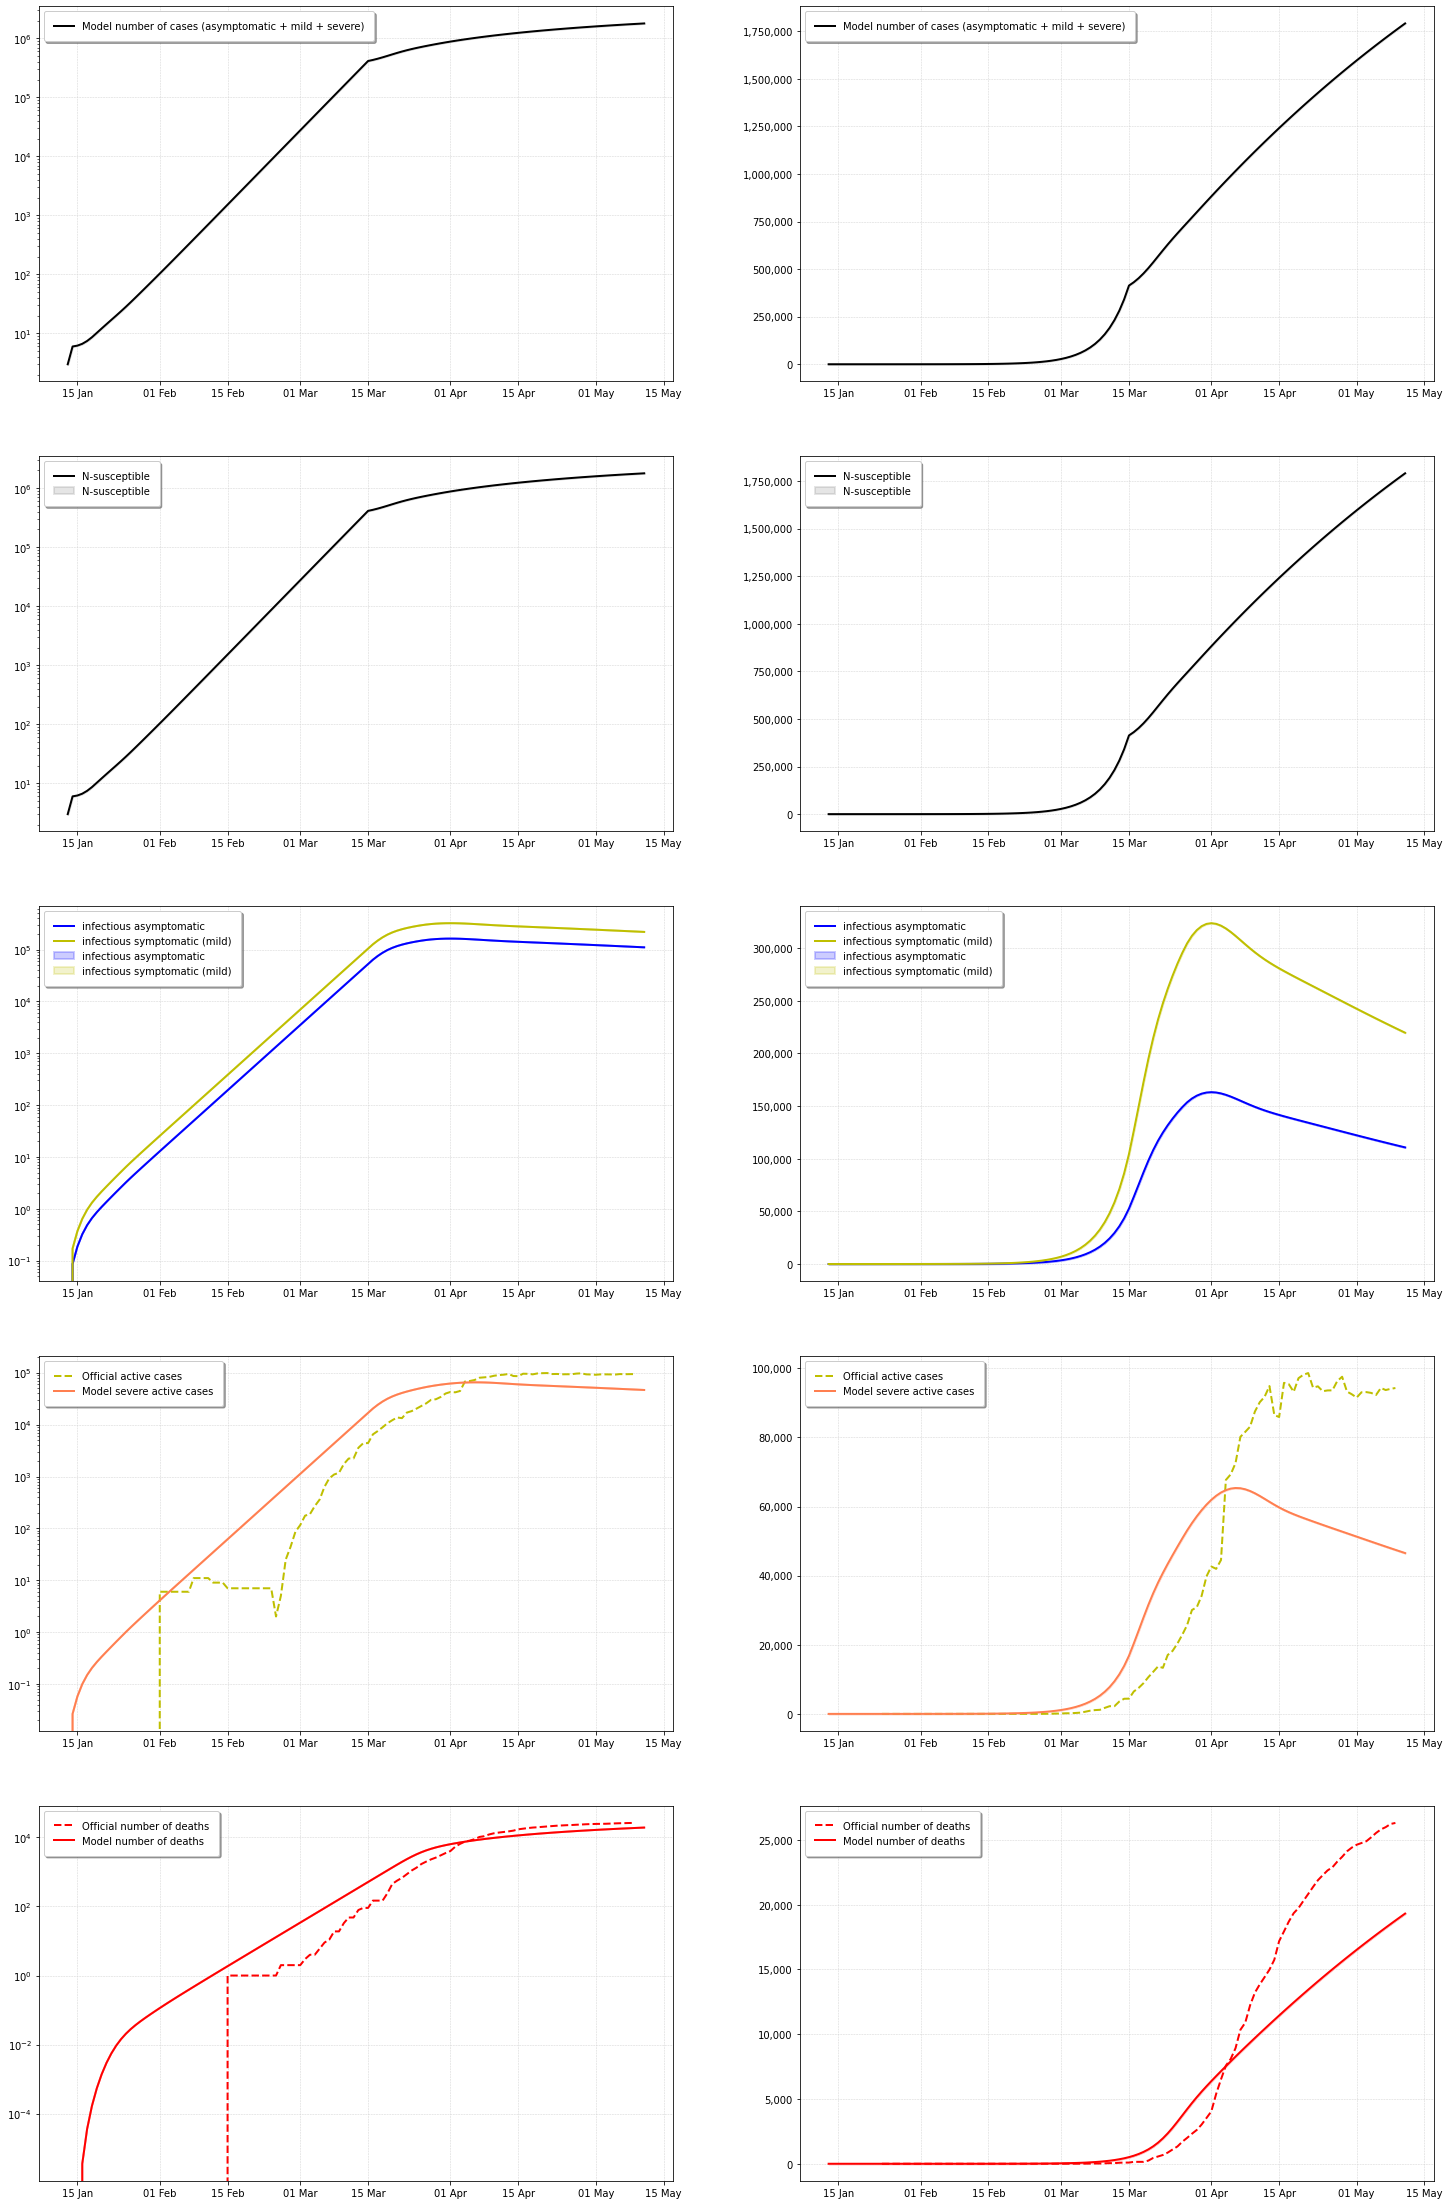

In [0]:
fig, axes = plt.subplots(5, 2, figsize=(25,40))
num_ = 8773

susceptible_ = rs[num_][0]
exposed_ = rs[num_][1]
infectiousA_ = rs[num_][2]
infectiousM_ = rs[num_][3]
infectiousSR_ = rs[num_][4]
infectiousSD_ = rs[num_][5]
infectiousA_cum = rs[num_][6]
infectiousM_cum = rs[num_][7]
infectiousSR_cum = rs[num_][8]
infectiousSD_cum = rs[num_][9]
recovered_ = rs[num_][10]
dead_ = rs[num_][11]

N=pm[num_]["N"]

lockdown_start = lockdown
lag = 0
init_delta=(min(lockdown_start["Date"].dt.date)-min(baseline_["Day"])).days
shift = rs[num_][12]-init_delta
datelist = pd.date_range(min(baseline_["Day"])-timedelta(shift), periods=len(susceptible_))

susceptible_["day"] = datelist
recovered_["day"] = datelist
infectiousA_["day"] = datelist
infectiousM_["day"] = datelist
infectiousSR_["day"] = datelist


infectiousSD_["day"] = datelist
recovered_["day"] = datelist
dead_["day"] = datelist

for j in range(0,2):


  if True:
    #shift = 7#pm[num_]["measures1_param"][0]-init_delta
    underestimation_infected = 1
    baseline_index_shifted = range(shift,shift+len(baseline_))
    #axes[0,j].plot(confirmed__["Date"]-timedelta(lag),confirmed__["TargetValue"]/underestimation_infected,linestyle='--',color="k",linewidth=2,label="Official confirmed cases")
    #axes[0,j].plot(baseline_index_shifted,baseline_["Dead"],linestyle='--',color="r",linewidth=2,label="baseline confirmed")
    #axes[0,j].plot(infectiousM_cum.quantile(q=0.5,axis=1),color="y",linewidth=2,label="infectious symptomatic (mild)")
    #axes[0,j].plot(infectiousSR_cum.quantile(q=0.5,axis=1),color="magenta",linewidth=2,label="infectious symptomatic (severed)")
    #axes[0,j].plot(infectiousSD_cum.quantile(q=0.5,axis=1),color="magenta",marker="o",linewidth=2,label="infectious symptomatic (severed)")
    #axes[3,j].plot(confirmed__["Date"]-timedelta(lag),confirmed__["TargetValue"].cumsum(),linestyle='--',color="y",linewidth=2,label="Official active cases")
    #axes[4,j].plot(dead__["Date"]-timedelta(lag),dead__["TargetValue"].cumsum(),linestyle='--',color="r",linewidth=2,label="Official number of deaths")
    
    axes[3,j].plot(baseline_["Day"]-timedelta(lag),baseline_["Active"],linestyle='--',color="y",linewidth=2,label="Official active cases")
    axes[4,j].plot(baseline_["Day"]-timedelta(lag),baseline_["Dead"],linestyle='--',color="r",linewidth=2,label="Official number of deaths")

  axes[0,j].plot(susceptible_.day,N-susceptible_.quantile(q=0.5,axis=1),color="k",linewidth=2,label="Model number of cases (asymptomatic + mild + severe)")
  axes[0,j].fill_between(susceptible_.day,N-susceptible_.quantile(q=0.2,axis=1),N-susceptible_.quantile(q=0.8,axis=1),color="grey", alpha=0.2,linewidth=2,label=None)
  #axes[0,j].plot(dead_.index,dead_.quantile(q=0.5,axis=1),color="r",linewidth=2,label="dead")
  #axes[0,j].fill_between(dead_.index,dead_.quantile(q=0.2,axis=1),dead_.quantile(q=0.8,axis=1),color="r", alpha=0.2,linewidth=2,label="dead")

  axes[1,j].plot(susceptible_.day,N-susceptible_.quantile(q=0.5,axis=1),color="k",linewidth=2,label="N-susceptible")
  axes[1,j].fill_between(susceptible_.day,N-susceptible_.quantile(q=0.2,axis=1),N-susceptible_.quantile(q=0.8,axis=1),color="grey", alpha=0.2,linewidth=2,label="N-susceptible")
  #axes[1,j].plot(recovered_.day,recovered_.quantile(q=0.5,axis=1),color="green",linewidth=2,label="recovered")
  #axes[1,j].fill_between(recovered_.day,recovered_.quantile(q=0.2,axis=1),recovered_.quantile(q=0.8,axis=1),color="green", alpha=0.2,linewidth=2,label="recovered")

  axes[2,j].plot(infectiousA_.day,infectiousA_.quantile(q=0.5,axis=1),color="b",linewidth=2,label="infectious asymptomatic")
  axes[2,j].fill_between(infectiousA_.day,infectiousA_.quantile(q=0.2,axis=1),infectiousA_.quantile(q=0.8,axis=1),color="b", alpha=0.2,linewidth=2,label="infectious asymptomatic")
  axes[2,j].plot(infectiousM_.day,infectiousM_.quantile(q=0.5,axis=1),color="y",linewidth=2,label="infectious symptomatic (mild)")
  axes[2,j].fill_between(infectiousM_.day,infectiousM_.quantile(q=0.2,axis=1),infectiousM_.quantile(q=0.8,axis=1),color="y", alpha=0.2,linewidth=2,label="infectious symptomatic (mild)")

  axes[3,j].plot(infectiousSR_.day,infectiousSR_.quantile(q=0.5,axis=1),color="coral",linewidth=2,label="Model severe active cases")
  axes[3,j].fill_between(infectiousSR_.day,infectiousSR_.quantile(q=0.2,axis=1),infectiousSR_.quantile(q=0.8,axis=1),color="coral", alpha=0.2,linewidth=2,label=None)
  #axes[3,j].plot(infectiousSD_.quantile(q=0.5,axis=1),color="coral",linewidth=2,linestyle='--',label="infectious symptomatic (severed death)")
  #axes[3,j].fill_between(infectiousSD_.index,infectiousSD_.quantile(q=0.2,axis=1),infectiousSD_.quantile(q=0.8,axis=1),color="coral",linestyle='--', alpha=0.2,linewidth=2,label="infectious symptomatic (severe death)")

  axes[4,j].plot(dead_.day,dead_.quantile(q=0.5,axis=1),color="red",linewidth=2,label="Model number of deaths")
  axes[4,j].fill_between(dead_.day,dead_.quantile(q=0.2,axis=1),dead_.quantile(q=0.8,axis=1),color="red", alpha=0.2,linewidth=2,label=None)
  for i in range(0,5):
  #  axes[i,j].set_xticks(range(0,len(rs[num_][11]),5))
    date_form = DateFormatter("%d %b")
    axes[i,j].xaxis.set_major_formatter(date_form)
    #axes[i,j].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    #axes[i,j].xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
    axes[i,j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axes[i,j].grid(color='lightgray', linestyle='--', linewidth=0.5)
    axes[i,j].legend(loc='upper left',fancybox=True, framealpha=1, shadow=True, borderpad=1)
    if j==0:
      axes[i,j].set_yscale("log")

display()

In [0]:
offset=pm[num_]["measures1_param"][0]-init_delta
writer = pd.ExcelWriter(f'{country}_offeset_{offset}_.xlsx', engine='xlsxwriter')

dfnames=["susceptible_",
            "exposed_",
            "infectiousA_",
            "infectiousSM_",
            "infectiousSS_",
            "infectiousA_cum",
            "infectiousSM_cum",
            "infectiousSS_cum" ,
            "infectiousSSR_cum",
            "infectiousSSD_cum",
            "recovered_" ,
            "dead_" ]
stats=[]
for i,df in enumerate([ susceptible_ ,
                    exposed_ ,
                    infectiousA_ ,
                    infectiousSM_ ,
                    infectiousSS_ ,
                    infectiousA_cum ,
                    infectiousSM_cum ,
                    infectiousSS_cum  ,
                    infectiousSSR_cum ,
                    infectiousSSD_cum ,
                    recovered_  ,
                    dead_  ]):
    print(dfnames[i],df.shape)
    df.to_excel(writer, sheet_name=dfnames[i])

    df_q=pd.DataFrame()
    df_q[dfnames[i]+"_low"]=df.quantile(0.2,axis=1)
    df_q[dfnames[i]+"median"]=df.quantile(0.5,axis=1)
    df_q[dfnames[i]+"high"]=df.quantile(0.8,axis=1)
    # df_q.to_excel(writer, sheet_name=dfnames[i]+"_Qstats")
    stats.append(df_q)

baseline_.to_excel(writer,sheet_name="baseline")

offsetdf=baseline_.reset_index(drop=True).loc[:offset]
offsetdf.loc[:,:]=np.nan
baseline_shifted=pd.concat([offsetdf,baseline_],ignore_index=True)
baseline_shifted.to_excel(writer,sheet_name="baseline_shifted")

dfqs=pd.concat(stats,axis=1)
dfqs.to_excel(writer,sheet_name="all_stats")

writer.save()
print(country)

susceptible_ (250, 100)
exposed_ (250, 100)
infectiousA_ (250, 100)
infectiousSM_ (250, 100)
infectiousSS_ (250, 100)
infectiousA_cum (250, 100)
infectiousSM_cum (250, 100)
infectiousSS_cum (250, 100)
infectiousSSR_cum (250, 100)
infectiousSSD_cum (250, 100)
recovered_ (250, 100)
dead_ (250, 100)
France
